In [1]:
import pandas as pd
import requests
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
from torch_geometric.data.batch import Batch
from torch_geometric.data import Data
from torch.utils.data import Dataset

In [3]:
scRNA_data = pd.read_csv('GSE200981_scRNAseq_processed.tsv', sep='\t')
scRNA_data.index = scRNA_data['Gene.names']
scRNA_data = scRNA_data.drop('Gene.names', axis=1)
len(scRNA_data)

26364

In [4]:
#Mapping string to protein names
string_api_url = "https://string-db.org/api"
output_format = "tsv-no-header"
method = "get_string_ids"

params = {

    "identifiers" : "\r".join(list(scRNA_data.index)), # your protein list
    "limit": 1,
    "echo_query": 1,
    "species" : 9606, # species NCBI identifier 
    "caller_identity" : "www.awesome_app.org" # your app name

}

request_url = "/".join([string_api_url, output_format, method])

results = requests.post(request_url, data=params)


protein_2_string = dict()
string_2_protein = dict()

for line in results.text.strip().split("\n"):
    l = line.split("\t")
    protein_identifier, string_identifier = l[0], l[2]
    protein_2_string[protein_identifier] = string_identifier
    string_2_protein[string_identifier] = protein_identifier

In [5]:
scRNA_data = scRNA_data.loc[list(protein_2_string.keys())]
scRNA_data

,V1_T0,V2_T0,V3_T0,V4_T0,V5_T0,V6_T0,V7_T0,V8_T0,V9_T0,V10_T0,...,V247_T7,V248_T7,V249_T7,V250_T7,V251_T7,V252_T7,V253_T7,V254_T7,V255_T7,V256_T7
Gene.names,,,,,,,,,,,,,,,,,,,,,
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAZ1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DAZ3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DAZ2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
import gc
torch.cuda.empty_cache()
gc.collect()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [7]:
device

device(type='cuda')

In [8]:
def get_all_protein_pairs(protein_list):
    protein_pairs = []
    for i in range(len(protein_list)):
        protein1 = protein_list[i]
        for j in range(i+1, len(protein_list)):
            protein2 = protein_list[j]
        
            protein_pairs.append((protein1, protein2))
            
    return protein_pairs

class Contrastive_Dataset(Dataset):
    def __init__(self, scRNA_data, string_2_protein, batch_size):
        self.counter = 0
        self.e_counter = 0
        self.m_counter = 0
        self.batch_size = batch_size
        filename = '9606.protein.links.v12.0.txt'

        file = open(filename, 'r')
        lines = file.readlines()
        lines.pop(0)

        string_2_index = dict()
        counter = 0
        for string_id in string_2_protein:
            string_2_index[string_id] = counter
            counter += 1

        list_network = list()
        
        """self.train_node_features = list()
        self.train_list_outputs = list()
        
        self.test_node_features = list()
        self.test_list_outputs = list()
        
        self.val_node_features = list()
        self.val_list_outputs = list()"""
        
        self.e_nodes = list()
        self.m_nodes = list()

        print('Getting network tensor...')
        for line in tqdm(lines):
            line = line.strip().split(' ')

            if int(line[2]) >= 999:

                try:
                    id1 = string_2_index[line[0]]
                    id2 = string_2_index[line[1]]
                    list_network.append([id1, id2])
                    list_network.append([id2, id1])

                except KeyError:
                    continue

        print('Getting node features tensor...')
        T0_column_vals = [column for column in scRNA_data.columns if 'T0' in column]
        T8_column_vals = [column for column in scRNA_data.columns if 'T7' in column]
        
        proteins = set([string_2_protein[string_id] for string_id in string_2_index])
        #train_proteins, test_proteins, validate_proteins = np.split(proteins, [int(len(proteins)*0.7), int(len(proteins*0.9))])
        
        #train_protein_pairs = get_all_protein_pairs(train_proteins)
        #testing_protein_pairs = get_all_protein_pairs(test_proteins)
        #validate_protein_pairs = get_all_protein_pairs(validate_proteins)
        
        #for 
        
        for column in T0_column_vals:   
            self.e_nodes.append(torch.tensor([scRNA_data.loc[protein, column] for protein in proteins], dtype=torch.float32).to(device))
                                        
        for column in T8_column_vals:
            self.m_nodes.append(torch.tensor([scRNA_data.loc[protein, column] for protein in proteins], dtype=torch.float32).to(device))
        
        self.edge_index = torch.tensor(list_network).t().contiguous()
        self.edge_index = self.edge_index.to(device)
        
        self.e_nodes = [i.view(len(i), 1) for i in self.e_nodes]
        self.m_nodes = [i.view(len(i), 1) for i in self.m_nodes]
        #self.len = len(self.e_nodes)
        #print(len(self.e_nodes), len(self.m_nodes))
    
    def __getitem__(self, idx):
        return self.e_nodes[idx], self.m_nodes[idx], self.edge_index
        """if self.counter == self.batch_size:
            self.counter = 0
        if self.counter < self.batch_size//2:
            self.counter += 1
            self.e_counter += 1
            return self.e_nodes[self.e_counter - 1], self.edge_index
        elif self.counter >= self.batch_size//2:
            self.counter += 1
            self.m_counter += 1
            return self.m_nodes[self.m_counter-1], self.edge_index"""
            
    def get_e_nodes(self):
        return self.e_nodes
    
    def get_m_nodes(self):
        return self.m_nodes#[0:10]
    
    def get_edge_index(self):
        return self.edge_index

    def shuffle(self):
        random.shuffle(self.e_nodes)
        random.shuffle(self.m_nodes)

    def __len__(self):
        return min(len(self.e_nodes), len(self.m_nodes))

In [9]:
def graph_collate_fn(batch):
    m_node_features = []
    e_node_features = []
    graph_list = []
    counter = 0
    batch_size = len(batch)
    
    for ex in batch:
        e_node, m_node, graph = ex
        num_nodes = e_node.shape[0]
        m_node_features.append(m_node)
        e_node_features.append(e_node)

    for i in range(batch_size):
        graph_list.append(graph + num_nodes*i)
    graphs_2 = graph_list[0:2]

    e_node_features = torch.stack(e_node_features, dim=0)
    e_node_features = torch.reshape(e_node_features, (e_node_features.shape[0]*e_node_features.shape[1], e_node_features.shape[2]))
    
    graphs = torch.cat(graph_list, 1)
    graphs_2 = torch.cat(graphs_2, 1)

    m_node_features = torch.stack(m_node_features, dim=0)
    m_node_features = torch.reshape(m_node_features, (m_node_features.shape[0]*m_node_features.shape[1], m_node_features.shape[2]))
    
    return e_node_features, m_node_features, graphs_2, graphs

In [10]:
batch_size = 20
contrastive_dataset = Contrastive_Dataset(scRNA_data, string_2_protein, batch_size)

Getting network tensor...


100%|██████████| 13715404/13715404 [00:07<00:00, 1862325.57it/s]


Getting node features tensor...


In [11]:
#contrastive_dataloader = DataLoader(contrastive_dataset, batch_size=batch_size, shuffle=True, collate_fn=graph_collate_fn)

In [12]:
def cosine_similarity(x1, x2, temp):
    return (torch.dot(x1.reshape(x1.shape[1]), x2.reshape(x2.shape[1]))/(torch.norm(x1)*torch.norm(x2)))/temp
    
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.temp = 1
    
    def forward(self, zn, zd):
        zi = zn[0, :, :]
        zj = zn[1, :, :].detach()
        num = torch.exp(cosine_similarity(zi, zj, self.temp))
        #print('Numerator')
        #print(num)

        #with torch.no_grad():
        denom = sum([torch.exp(cosine_similarity(zi, zd[i, :, :].detach(), self.temp)) for i in range(zd.shape[0])])
        #print('Denominator')
        #print(denom)
        return torch.multiply(torch.log(torch.divide(num, denom)), -1)

In [13]:
def train_model(epochs, dataset, gat, mlp, optimizer):
    torch.cuda.empty_cache()
    criterion = ContrastiveLoss()
    plot_losses = []
    for _ in tqdm(range(epochs)):
        dataset.shuffle()
        dataloader = DataLoader(dataset, batch_size=10, shuffle=False, collate_fn=graph_collate_fn)
        torch.cuda.empty_cache()
        
        for batch in dataloader:
            batch_losses = []
            e_nodes, m_nodes, graphs_2, graphs = batch
            batch_size = e_nodes.shape[0]//18840
            e_nodes_unstacked = torch.reshape(e_nodes, (batch_size, 1, -1))

            zd = gat(m_nodes, graphs)
            zd = mlp(zd)

            all_losses = []
            for i in range(e_nodes_unstacked.shape[0]):
                xi = e_nodes_unstacked[i]
                #print(xi)
                for j in range(e_nodes_unstacked.shape[0]):
                    if i == j: continue
                    xj = e_nodes_unstacked[j]
                    xn = torch.stack([xi, xj], dim=0)
                    xn = torch.reshape(xn, (xn.shape[0]*xn.shape[2], xn.shape[1]))
                    zn = gat(xn, graphs_2)
                    zn = mlp(zn)

                    loss = criterion(zn, zd)
                    #print(loss)
                    all_losses.append(loss)
                    
            #final_loss = sum(all_losses)/len(all_losses)
            #batch_losses.append(final_loss.item())
            #print(final_loss)
            #final_loss.backward()
            #optimizer.step()
            #final_loss.detach()

            m_nodes_unstacked = torch.reshape(m_nodes, (batch_size, 1, -1))

            zd = gat(e_nodes, graphs)
            zd = mlp(zd)

            #all_losses = []
            for i in range(m_nodes_unstacked.shape[0]):
                xi = m_nodes_unstacked[i]
                #print(xi)
                for j in range(m_nodes_unstacked.shape[0]):
                    if i == j: continue
                    xj = m_nodes_unstacked[j]
                    xn = torch.stack([xi, xj], dim=0)
                    xn = torch.reshape(xn, (xn.shape[0]*xn.shape[2], xn.shape[1]))
                    zn = gat(xn, graphs_2)
                    zn = mlp(zn)

                    loss = criterion(zn, zd)
                    all_losses.append(loss)
                    
            final_loss = sum(all_losses)/len(all_losses)
            batch_losses.append(final_loss.item())
            #print(final_loss)
            final_loss.backward()
            optimizer.step()
            #final_loss.detach()
        plot_losses.append(sum(batch_losses)/len(batch_losses)) 
        print(plot_losses)
    return plot_losses

In [18]:
class GAT_Contrast(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()

        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout = 0.6)
        #self.conv2 = GATConv(hidden_channels*heads, out_channels, heads, dropout=0.6)
        self.num_nodes = 18840
        self.output_layer = nn.Linear(self.num_nodes*hidden_channels*heads, out_channels)
        #self.columns = out_channels*heads

    def forward(self, x, edge_index):
        batch_size = x.shape[0]//self.num_nodes
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = torch.reshape(x, (batch_size, 1, -1))

        x = self.output_layer(x)
        x = F.relu(x)
        return x

class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.linear1 = nn.Linear(in_channels, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, out_channels)
        self.num_nodes = 18840

    def forward(self, x):
        #batch_size = x.shape[0]//self.num_nodes
        #x = torch.reshape(x, (batch_size, 1, -1))
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        return x

In [19]:
import torch_geometric.utils
from torch_geometric.nn import GATConv

def GAT_contrast_train(gat, mlp, dataset, epochs, num_nodes, lr = 1e-6, weight_decay = 5e-4, temp=0.05):
    torch.cuda.empty_cache()
    params = list(gat.parameters()) + list(mlp.parameters())
    optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    criterion = ContrastiveLoss()
    gat.train()
    mlp.train()
    optimizer.zero_grad()

    losses = train_model(epochs, dataset, gat, mlp, optimizer)
    return losses

In [22]:
#Need to put in tensor batches again
gat_contrast = GAT_Contrast(1, 8, 64, 2).to(device)
mlp_contrast = MLP(64, 32, 16).to(device)

In [23]:
losses = GAT_contrast_train(gat_contrast, mlp_contrast, contrastive_dataset, 100, scRNA_data.shape[0])

  1%|          | 1/100 [00:25<41:46, 25.31s/it]

[1.7546837329864502]


  2%|▏         | 2/100 [00:50<41:06, 25.17s/it]

[1.7546837329864502, 1.5517641305923462]


  3%|▎         | 3/100 [01:15<40:32, 25.07s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676]


  4%|▍         | 4/100 [01:40<40:03, 25.04s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606]


  5%|▌         | 5/100 [02:05<39:34, 24.99s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361]


  6%|▌         | 6/100 [02:30<39:03, 24.93s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316]


  7%|▋         | 7/100 [02:54<38:33, 24.87s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666]


  8%|▊         | 8/100 [03:19<38:15, 24.95s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574]


  9%|▉         | 9/100 [03:44<37:46, 24.91s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814]


 10%|█         | 10/100 [04:09<37:05, 24.73s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813]


 11%|█         | 11/100 [04:33<36:34, 24.65s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572]


 12%|█▏        | 12/100 [04:57<35:59, 24.54s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685]


 13%|█▎        | 13/100 [05:22<35:31, 24.50s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117]


 14%|█▍        | 14/100 [05:46<34:58, 24.40s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762]


 15%|█▌        | 15/100 [06:10<34:22, 24.26s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017]


 16%|█▌        | 16/100 [06:34<33:46, 24.12s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734]


 17%|█▋        | 17/100 [06:57<33:15, 24.04s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786]


 18%|█▊        | 18/100 [07:21<32:44, 23.95s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197]


 19%|█▉        | 19/100 [07:45<32:15, 23.90s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606]


 20%|██        | 20/100 [08:09<31:52, 23.90s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047]


 21%|██        | 21/100 [08:33<31:25, 23.86s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545]


 22%|██▏       | 22/100 [08:57<31:00, 23.85s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854]


 23%|██▎       | 23/100 [09:20<30:38, 23.88s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697]


 24%|██▍       | 24/100 [09:44<30:14, 23.87s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371]


 25%|██▌       | 25/100 [10:08<29:50, 23.87s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121]


 26%|██▌       | 26/100 [10:32<29:29, 23.91s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247]


 27%|██▋       | 27/100 [10:56<29:04, 23.89s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321]


 28%|██▊       | 28/100 [11:20<28:40, 23.90s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281]


 29%|██▉       | 29/100 [11:44<28:18, 23.93s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787]


 30%|███       | 30/100 [12:08<27:52, 23.89s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552]


 31%|███       | 31/100 [12:32<27:26, 23.86s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688]


 32%|███▏      | 32/100 [12:55<27:02, 23.86s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431]


 33%|███▎      | 33/100 [13:19<26:36, 23.83s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091]


 34%|███▍      | 34/100 [13:43<26:11, 23.82s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583]


 35%|███▌      | 35/100 [14:07<25:50, 23.85s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954]


 36%|███▌      | 36/100 [14:31<25:24, 23.82s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934]


 37%|███▋      | 37/100 [14:54<24:57, 23.76s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224]


 38%|███▊      | 38/100 [15:18<24:34, 23.78s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559]


 39%|███▉      | 39/100 [15:42<24:10, 23.78s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801]


 40%|████      | 40/100 [16:05<23:44, 23.74s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106]


 41%|████      | 41/100 [16:29<23:21, 23.76s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022]


 42%|████▏     | 42/100 [16:53<22:57, 23.75s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467]


 43%|████▎     | 43/100 [17:17<22:33, 23.75s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319]


 44%|████▍     | 44/100 [17:41<22:11, 23.77s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471]


 45%|████▌     | 45/100 [18:04<21:46, 23.75s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342]


 46%|████▌     | 46/100 [18:28<21:22, 23.75s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917]


 47%|████▋     | 47/100 [18:52<21:00, 23.79s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167]


 48%|████▊     | 48/100 [19:16<20:36, 23.78s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583]


 49%|████▉     | 49/100 [19:39<20:12, 23.78s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821]


 50%|█████     | 50/100 [20:03<19:50, 23.81s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772]


 51%|█████     | 51/100 [20:27<19:26, 23.81s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 52%|█████▏    | 52/100 [20:51<19:01, 23.78s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 53%|█████▎    | 53/100 [21:15<18:38, 23.80s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 54%|█████▍    | 54/100 [21:38<18:13, 23.78s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 55%|█████▌    | 55/100 [22:02<17:48, 23.74s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 56%|█████▌    | 56/100 [22:26<17:26, 23.77s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 57%|█████▋    | 57/100 [22:50<17:01, 23.75s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 58%|█████▊    | 58/100 [23:13<16:38, 23.78s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 59%|█████▉    | 59/100 [23:37<16:16, 23.81s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 60%|██████    | 60/100 [24:01<15:51, 23.78s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 61%|██████    | 61/100 [24:25<15:26, 23.75s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 62%|██████▏   | 62/100 [24:49<15:04, 23.80s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 63%|██████▎   | 63/100 [25:12<14:39, 23.78s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 64%|██████▍   | 64/100 [25:36<14:16, 23.79s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 65%|██████▌   | 65/100 [26:00<13:53, 23.81s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 66%|██████▌   | 66/100 [26:24<13:28, 23.78s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 67%|██████▋   | 67/100 [26:47<13:04, 23.76s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 68%|██████▊   | 68/100 [27:11<12:41, 23.80s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 69%|██████▉   | 69/100 [27:35<12:16, 23.76s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 70%|███████   | 70/100 [27:59<11:52, 23.74s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 71%|███████   | 71/100 [28:23<11:28, 23.76s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 72%|███████▏  | 72/100 [28:46<11:04, 23.73s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 73%|███████▎  | 73/100 [29:10<10:41, 23.74s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 74%|███████▍  | 74/100 [29:34<10:18, 23.80s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 75%|███████▌  | 75/100 [29:58<09:55, 23.80s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 76%|███████▌  | 76/100 [30:22<09:31, 23.81s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 77%|███████▋  | 77/100 [30:46<09:08, 23.86s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 78%|███████▊  | 78/100 [31:09<08:42, 23.76s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 79%|███████▉  | 79/100 [31:33<08:18, 23.72s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 80%|████████  | 80/100 [31:56<07:54, 23.73s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 81%|████████  | 81/100 [32:20<07:30, 23.73s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 82%|████████▏ | 82/100 [32:44<07:06, 23.71s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 83%|████████▎ | 83/100 [33:07<06:42, 23.69s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 84%|████████▍ | 84/100 [33:31<06:18, 23.63s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 85%|████████▌ | 85/100 [33:55<05:54, 23.63s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 86%|████████▌ | 86/100 [34:18<05:31, 23.71s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 87%|████████▋ | 87/100 [34:42<05:08, 23.73s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 88%|████████▊ | 88/100 [35:06<04:44, 23.73s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 89%|████████▉ | 89/100 [35:30<04:21, 23.76s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 90%|█████████ | 90/100 [35:53<03:56, 23.65s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 91%|█████████ | 91/100 [36:17<03:32, 23.64s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 92%|█████████▏| 92/100 [36:41<03:09, 23.67s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 93%|█████████▎| 93/100 [37:04<02:45, 23.62s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 94%|█████████▍| 94/100 [37:28<02:21, 23.60s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 95%|█████████▌| 95/100 [37:51<01:58, 23.64s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 96%|█████████▌| 96/100 [38:15<01:34, 23.60s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 97%|█████████▋| 97/100 [38:38<01:10, 23.59s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 98%|█████████▊| 98/100 [39:02<00:47, 23.50s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

 99%|█████████▉| 99/100 [39:25<00:23, 23.54s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

100%|██████████| 100/100 [39:49<00:00, 23.89s/it]

[1.7546837329864502, 1.5517641305923462, 1.1961331367492676, 1.253907322883606, 0.9549305438995361, 0.8409180641174316, 0.9344982504844666, 1.2062411308288574, 0.9092323780059814, 0.8683468103408813, 0.8000071048736572, 0.8883180022239685, 0.8412086367607117, 0.7984576225280762, 0.8122421503067017, 0.8028316497802734, 0.7998448610305786, 0.7978290915489197, 0.8049805760383606, 0.8091869354248047, 0.7977853417396545, 0.7969744205474854, 0.796508252620697, 0.7954268455505371, 0.8045516014099121, 0.8010838627815247, 0.7954719662666321, 0.7953111529350281, 0.8017899990081787, 0.796161949634552, 0.8023525476455688, 0.7956680655479431, 0.7938088774681091, 0.7961350679397583, 0.7989593744277954, 0.7959492802619934, 0.7930888533592224, 0.7953541874885559, 0.7942318916320801, 0.7957602739334106, 0.793613076210022, 0.7935414910316467, 0.7935348153114319, 0.7948523163795471, 0.7943196892738342, 0.7933995127677917, 0.7942845225334167, 0.7932013869285583, 0.795397937297821, 0.7943454384803772, 0.79

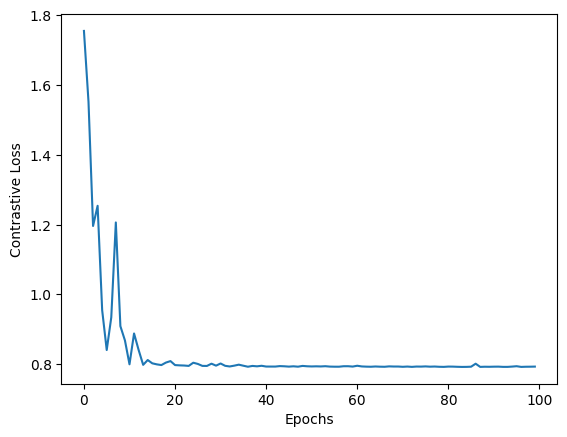

In [24]:
plt.plot([i for i in range(len(losses))], losses)
plt.xlabel('Epochs')
plt.ylabel('Contrastive Loss')
plt.show()

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [29]:
def RFC_test(model, dataset):
    model.eval()
    
    e_nodes = dataset.get_e_nodes()
    m_nodes = dataset.get_m_nodes()
    edge_index = dataset.get_edge_index()

    x = e_nodes + m_nodes
    x = [model(i, edge_index).reshape(-1).detach().cpu().numpy() for i in x]
    y = [0 for _ in range(len(e_nodes))] + [1 for _ in range(len(m_nodes))]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
 
    rf = RandomForestClassifier()
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)

In [30]:
RFC_test(gat_contrast, contrastive_dataset)

1.0
